In [1]:
%load_ext autoreload
%autoreload 2

### 2. Test the Foward part of the Network
> * Now make sure that we can map from an image into an SxSx2x11 Tensor
> * First make sure that the Yolo2 weights are loadable and make sense.

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from Model.vis_utils import visualize_grid

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# l2 = np.array(list((yolo_weights['model_weights']['conv2d_1']['conv2d_1'][u'kernel:0'])))
# grid = visualize_grid(l2.transpose(3, 1, 2, 0))
# print (grid.shape, l2.shape)
# plt.imshow(grid.astype('uint8'))
# plt.axis('off')
# plt.gcf().set_size_inches(5, 5)
# plt.show()

#### 2.1 Overfit Localizer in Tiny Data
> * For debugging, we run the foward, and backward pass for `a few`
epochs.

In [4]:
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import NutritionDataset
from Model.net import LocalizerNet
from train import train_localizer, calculate_iou

0.4.0


In [8]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/RawImages/'
    BOXES = '../Data/FullData/BoundingBoxes.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    YOLO_PATH = '../Data/FullData/yolo.h5'
    debug=torch.cuda.is_available()
    dataset = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, debug=debug),
        batch_size=32, shuffle=True, num_workers=4,
    )
    dev = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH, split='dev', debug=debug),
        batch_size=32, shuffle=True, num_workers=4,
    )
    model = LocalizerNet(YOLO_PATH)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4
    )
    r = train_localizer(model, optimizer, dataset, dev, epochs=500)
    return r    

In [9]:
train_losses, dev_losses, train_map, dev_map = train_localizer_network()

=== Performance Check ===
	 Train Loss =  0.09389075636863708
	 Dev Loss =  0.0927969440817833
	 Train mAP =  0.0
	 Dev mAP =  0.0
=== Performance Check ===
	 Train Loss =  0.026367055252194405
	 Dev Loss =  0.0717494860291481
	 Train mAP =  0.0
	 Dev mAP =  0.0
=== Performance Check ===
	 Train Loss =  0.009671631269156933
	 Dev Loss =  0.0667131319642067
	 Train mAP =  0.0
	 Dev mAP =  0.0
=== Performance Check ===
	 Train Loss =  0.0036676672752946615
	 Dev Loss =  0.06563720852136612
	 Train mAP =  0.1
	 Dev mAP =  0.0
=== Performance Check ===
	 Train Loss =  0.001459591556340456
	 Dev Loss =  0.06525111198425293
	 Train mAP =  0.5
	 Dev mAP =  0.0
=== Performance Check ===
	 Train Loss =  0.0006020980072207749
	 Dev Loss =  0.06504605710506439
	 Train mAP =  0.4
	 Dev mAP =  0.0
=== Performance Check ===
	 Train Loss =  0.000198532929061912
	 Dev Loss =  0.06440595537424088
	 Train mAP =  0.9
	 Dev mAP =  0.0
=== Performance Check ===
	 Train Loss =  7.109620491974056e-05
	 Dev L

Process Process-1365:
Process Process-1368:
Process Process-1367:
Process Process-1366:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/mul

KeyboardInterrupt: 

In [10]:
def plot(train, dev, title):
    plt.title(title)
    plt.plot(train, label='train'); plt.plot(dev, label='dev')
    plt.xlabel('Iteration')
    plt.show()

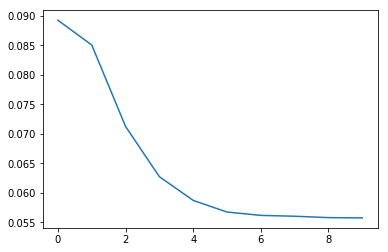

In [11]:
plt.plot(dev_losses)

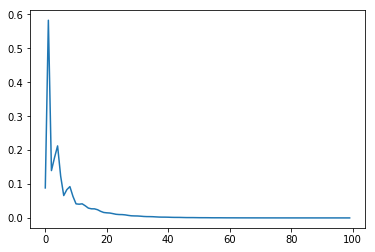

In [12]:
plt.plot(train_losses)

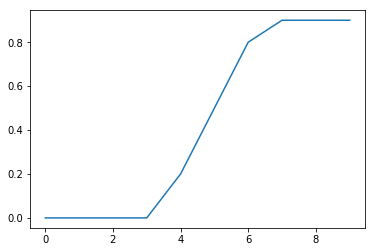

In [13]:
plt.plot(train_map)